### **Inference Overview**

In this section, we perform inference using our Chem_Fuser model on a benchmark dataset of **10,000 SMILES**. These SMILES were generated by an entirely separate Transformer-based generative model and were not seen during training, making this a true out-of-distribution test.

##
To simulate realistic noise conditions, we applied random **forward diffusion masking** with corruption levels sampled uniformly between **0.15 and 0.7**. This masks different proportions of each input SMILES, challenging the model to recover the original structure from partial information.

##
This evaluation setup serves as a **baseline benchmark** for future model iterations and helps measure how well the model generalizes beyond its training distribution.

##
*Note: The generated SMILES tend to be slightly longer than the original training set, adding an extra layer of difficulty during unmasking.*

In [1]:
import os
import sys
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

project_root = os.path.abspath("..")  
sys.path.append(project_root)

from model import DiffusionModel
from vocab import Vocabulary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
masked_file = "masked_test_set.txt"              # Pre-masked tensor
original_file = "test_set.txt"  # Original SMILES
checkpoint_path = "../checkpoints/Diffusion_final-2.ckpt"
vocab_file = "../data/voc.txt"
output_file = "inference/unmasked_output.csv"
batch_size = 128

In [3]:
# Load vocabulary and model 
voc = Vocabulary(vocab_file)
model = DiffusionModel(voc)
checkpoint = torch.load(checkpoint_path, map_location=device)

# Remove '_orig_mod.' prefix from keys if it exists
new_state_dict = {}
for k, v in checkpoint.items():
    if k.startswith("_orig_mod."):
        new_key = k.replace("_orig_mod.", "")
    else:
        new_key = k
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict)
model.to(device).eval()

pad_token = voc.vocab["[PAD]"]
mask_token = voc.vocab["[MASK]"]


In [4]:
def strip_pad(seq, pad_idx):
    return [i for i in seq if i != pad_idx]

def estimate_t_per_sequence(batch_tensor, mask_token, pad_token):
    mask = (batch_tensor == mask_token)
    valid = (batch_tensor != pad_token)
    t_vals = mask.sum(dim=1).float() / valid.sum(dim=1).float()
    return t_vals.clamp(0.0, 1.0)

In [5]:
with open(masked_file) as f:
    masked_smiles = [line.strip() for line in f if line.strip()]

with open(original_file) as f:
    original_smiles = [line.strip() for line in f if line.strip()]

assert len(masked_smiles) == len(original_smiles), "Mismatch in SMILES counts"

In [6]:
# Tokenize + encode
encoded = [torch.tensor(voc.encode(voc.tokenize(smi)), dtype=torch.long) for smi in masked_smiles]
max_len = max(len(seq) for seq in encoded)
padded = [F.pad(seq, (0, max_len - len(seq)), value=pad_token) for seq in encoded]
masked_tensor = torch.stack(padded).to(device)  # (10000, max_len)


In [7]:
# Inference
masked_out = []
predicted_out = []

with torch.no_grad():
    for i in tqdm(range(0, len(masked_tensor), batch_size)):
        batch = masked_tensor[i:i+batch_size]
        t_vals = estimate_t_per_sequence(batch, mask_token, pad_token).to(device)

        logits = model.model(batch, t=t_vals)
        probs = F.softmax(logits, dim=-1)
        pred_ids = torch.argmax(probs, dim=-1)

        # Replace [MASK] only
        unmasked = batch.clone()
        unmasked[batch == mask_token] = pred_ids[batch == mask_token]

        # Decode
        for j in range(batch.size(0)):
            masked_seq = voc.decode(strip_pad(batch[j].tolist(), pad_token))
            pred_seq = voc.decode(strip_pad(unmasked[j].tolist(), pad_token))
            masked_out.append(masked_seq)
            predicted_out.append(pred_seq)

# Validate predicted SMILES 
print("Validating SMILES")
is_valid = []
valid_count = 0

for smi in predicted_out:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        is_valid.append(True)
        valid_count += 1
    else:
        is_valid.append(False)

# Save to CSV 
output_file = "inference_data.csv"

print("Saving output...")

output_dir = os.path.dirname(output_file)
if output_dir:
    os.makedirs(output_dir, exist_ok=True)
    
df = pd.DataFrame({
    "True_SMILES": original_smiles,
    "Corrupted_SMILES": masked_out,
    "Recovered_SMILES": predicted_out,
    "Is_Valid": is_valid
})

df.to_csv(output_file, index=False)

# Summary 
total = len(predicted_out)
percent = 100 * valid_count / total

  0%|          | 0/79 [00:00<?, ?it/s]/opt/anaconda3/envs/deepchem_env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
 41%|████      | 32/79 [00:13<00:18,  2.58it/s]

In [ ]:
print(f"\nSaved {total} entries to {output_file}")
print(f"Valid SMILES: {valid_count}/{total} ({percent:.2f}%)")


Saved 10000 entries to inference_data.csv
Valid SMILES: 6400/10000 (64.00%)


In [ ]:
def unmask_single_smiles(masked_smi, model, vocab, device):
    """
    Unmasks a single SMILES string using a trained diffusion model.
    
    Args:
        masked_smi (str): SMILES string containing [MASK] tokens.
        model (nn.Module): Trained diffusion model with `.model` attribute.
        vocab (Vocabulary): Vocabulary object for encoding/decoding.
        device (torch.device): Device to run inference on.
    
    Returns:
        str: Predicted (unmasked) SMILES string.
    """
    pad_token = vocab.vocab["[PAD]"]
    mask_token = vocab.vocab["[MASK]"]

    encoded = vocab.encode(vocab.tokenize(masked_smi))
    encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        t_val = estimate_t_per_sequence(encoded_tensor, mask_token, pad_token).to(device)
        logits = model.model(encoded_tensor, t=t_val)
        probs = F.softmax(logits, dim=-1)
        pred_ids = torch.argmax(probs, dim=-1)

        unmasked = encoded_tensor.clone()
        unmasked[encoded_tensor == mask_token] = pred_ids[encoded_tensor == mask_token]

        def strip_pad(seq): return [i for i in seq if i != pad_token]
        predicted_smi = vocab.decode(strip_pad(unmasked[0].tolist()))

    return predicted_smi

Masked   : [MASK]C[MASK][MASK]O[MASK]N1[MASK][MASK][MASK][MASK][MASK][MASK]=O[MASK][MASK][MASK]O)c2[MASK][MASK][MASK]c[MASK][MASK][MASK][MASK]2[MASK][MASK]c([MASK][MASK][MASK][MASK][MASK])[MASK][MASK]1
Recovered: CC(=O)N1CCN(S(=O)(=O)c2ccccc2-c2ccc(Cl)cc2)CC1


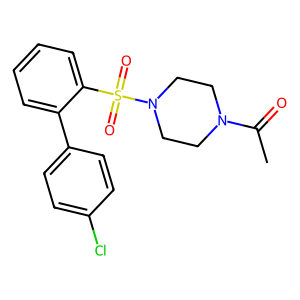

In [ ]:
masked_smi = "[MASK]C[MASK][MASK]O[MASK]N1[MASK][MASK][MASK][MASK][MASK][MASK]=O[MASK][MASK][MASK]O)c2[MASK][MASK][MASK]c[MASK][MASK][MASK][MASK]2[MASK][MASK]c([MASK][MASK][MASK][MASK][MASK])[MASK][MASK]1"
result = unmask_single_smiles(masked_smi, model, voc, device)

print("Masked   :", masked_smi)
print("Recovered:", result)

#visualize unmasked smile
mol = Chem.MolFromSmiles(result)
Draw.MolToImage(mol)

### **Inference Conclusion**

Out of 10,000 masked SMILES inputs, our model successfully recovered 6,400 valid SMILES, resulting in a validity rate of 64.00%.

This is a strong starting point, especially considering the benchmark set was completely out-of-distribution, composed of synthetic SMILES generated by a different model and likely longer or more complex than the training data.

This benchmark can now serve as a reference to measure the generalization ability and future improvements of the Chem_Fuser model.
